<a href="https://colab.research.google.com/github/menon92/WaveletCNN/blob/master/waveletCNN_Keras_0_6_%5BExp_on_10K_data%5D_grayscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
from matplotlib import pyplot as plt

from keras import backend as K
from keras.models import Model

from keras.layers.merge import add, concatenate
from keras.layers import Input, Dense, Conv2D, Lambda
from keras.layers import Flatten, Reshape, Dropout, Activation
from keras.layers import AveragePooling2D, BatchNormalization

from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

In [50]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [51]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
  
    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)
 
    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2] 
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    return [tuple([None, 112, 112, 4]), tuple([None, 56, 56, 4]), 
            tuple([None, 28, 28, 4]), tuple([None, 14, 14, 4])]

In [52]:
img_batch = K.zeros(shape=(2, 224, 224, 1), dtype='float32')
decom_level_1, decom_level_2, decom_level_3, decom_level_4 = Wavelet(img_batch)

print(decom_level_1.shape, decom_level_2.shape, decom_level_3.shape, decom_level_4.shape)

(2, 112, 112, 4) (2, 56, 56, 4) (2, 28, 28, 4) (2, 14, 14, 4)


In [53]:
def get_wavelet_cnn_model():

    input_shape = 224, 224, 1

    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 

    fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    norm_5 = BatchNormalization(name='norm_5')(fc_5)
    relu_5 = Activation('relu', name='relu_5')(norm_5)
    drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    fc_6 = Dense(2048, name='fc_6')(drop_5)
    norm_6 = BatchNormalization(name='norm_6')(fc_6)
    relu_6 = Activation('relu', name='relu_6')(norm_6)
    drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(2, activation='softmax', name='fc_7')(drop_6)

    model = Model(inputs=input_, outputs=output)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')

    return model

In [54]:
model = get_wavelet_cnn_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 wavelet (Lambda)               [(None, 112, 112, 4  0           ['the_input[0][0]']              
                                ),                                                                
                                 (None, 56, 56, 4),                                               
                                 (None, 28, 28, 4),                                               
                                 (None, 14, 14, 4)]                                         

In [55]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [42]:
!kaggle datasets list -s cat

ref                                                     title                                      size  lastUpdated          downloadCount  
------------------------------------------------------  ----------------------------------------  -----  -------------------  -------------  
crawford/cat-dataset                                    Cat Dataset                                 4GB  2018-02-16 23:41:25          18237  
tongpython/cat-and-dog                                  Cat and Dog                               218MB  2018-04-26 10:56:50          50735  
d4rklucif3r/cat-and-dogs                                Cat & Dogs                                218MB  2021-06-07 11:39:13            670  
ma7555/cat-breeds-dataset                               Cat Breeds Dataset                          2GB  2019-12-12 12:42:00           3347  
mriganksingh/cat-images-dataset                         Cat images Dataset                          3MB  2019-04-13 20:24:18           1692  
harrik

In [43]:
!kaggle datasets download -d chetankv/dogs-cats-images

dogs-cats-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [44]:
!unzip -qq /content/dogs-cats-images.zip

replace dataset/test_set/cats/cat.4001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/test_set/cats/cat.4002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/test_set/cats/cat.4003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [46]:
import os
data_set_path = '/content/dog vs cat/dataset'
os.listdir(data_set_path)

['test_set', 'training_set']

In [56]:
train_data_gen = ImageDataGenerator(
	#rescale=1./255,
	shear_range=0.1,
	zoom_range=0.1,
	horizontal_flip=True
)
val_data_gen = ImageDataGenerator(
	#rescale=1./255
)

train_img_dir = '/content/dog vs cat/dataset/training_set'
val_img_dir   = '/content/dog vs cat/dataset/test_set'

# def train & test generators
train_generator = train_data_gen.flow_from_directory(
	train_img_dir,
	target_size=(224, 224),
	batch_size=32,
	class_mode='categorical',
	color_mode='grayscale'
)
val_generator = val_data_gen.flow_from_directory(
	val_img_dir,
	target_size=(224, 224),
	batch_size=32,
	class_mode='categorical',
	color_mode='grayscale'
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [57]:
history = model.fit_generator(
	train_generator,
	steps_per_epoch=8000//32,
	epochs=2,
	validation_data=val_generator,
    validation_steps=2000//32,
	verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/2
250/250 [==============================] - 87s 334ms/step - loss: 0.8852 - accuracy: 0.5634 - val_loss: 1.3827 - val_accuracy: 0.5968
Epoch 2/2
250/250 [==============================] - 81s 325ms/step - loss: 0.7297 - accuracy: 0.6409 - val_loss: 1.4619 - val_accuracy: 0.5938


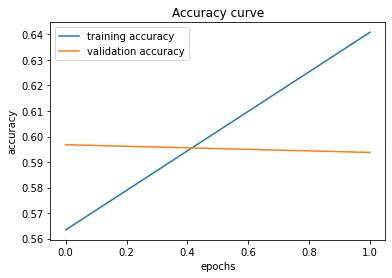

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

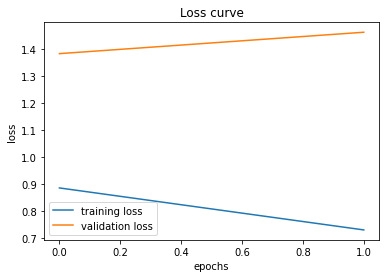

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()